<a href="https://colab.research.google.com/github/ajaykurani/DataAugmentation/blob/master/LearnDataAug_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras==2.2.2
!pip install tensorflow==1.9.0
!pip install git+https://github.com/raghakot/keras-vis.git
!pip install git+https://github.com/raghakot/keras-vis.git --upgrade

     |████████████████████████████████| 307kB 2.8MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
ERROR: tensorflow 2.3.0 has requirement keras-preprocessing<1.2,>=1.1.1, but you'll have keras-preprocessing 1.0.2 which is incompatible.
  Found existing installation: Keras-Preprocessing 1.1.2
    Uninstalling Keras-Preprocessing-1.1.2:
      Successfully uninstalled Keras-Preprocessing-1.1.2
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 51.1MB 56kB/s 
     |████████████████████████████████| 3.3MB 32.4MB/s 
     |████████████████████████████████| 573kB 35.8MB/s 
ERROR: xarray 0.15.1 has requirement setuptools>=41.2, but you'll have setuptools 39.1.0 which is incompatible.
ERROR: google-auth 1.17.2 has requirement setuptools>=40.3.0, but you'll have setuptools 39.1.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0

  Cloning https://github.com/raghakot/keras-vis.git to /tmp/pip-req-build-jekhbx6z
  Running command git clone -q https://github.com/raghakot/keras-vis.git /tmp/pip-req-build-jekhbx6z
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=38887 sha256=fbf5790bd0d2cbc1fe81d8e2f8e99f332e14287f0d8d485c926a8b24edadcd1c
  Stored in directory: /tmp/pip-ephem-wheel-cache-ejr4w7_p/wheels/c5/ae/e7/b34d1cb48b1898f606a5cce08ebc9521fa0588f37f1e590d9f
Successfully built keras-vis
  Found existing installation: keras-vis 0.4.1
    Uninstalling keras-vis-0.4.1:
      Successfully uninstalled keras-vis-0.4.1
  Cloning https://github.com/raghakot/keras-vis.git to /tmp/pip-req-build-086kx2ry
  Running command git clone -q https://github.com/raghakot/keras-vis.git /tmp/pip-req-build-086kx2ry
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=38887 sha256=8d2bed2870ebd9d709f79c7c32c717942e7f285b428ef4c32ce65a46f72e1964
  Stored in directory: /tmp/p

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from scipy.ndimage import rotate
import random
import torch.nn.functional as nnf
!pip install git+https://github.com/kornia/kornia
import kornia as K
from kornia.augmentation import RandomRotation

!cp "/content/drive/My Drive/lib/datasets.py" .
!cp "/content/drive/My Drive/lib/autoencoder.py" .
!cp "/content/drive/My Drive/lib/cnn.py" .
# !cp "/content/drive/My Drive/lib/vae.py" .
!cp "/content/drive/My Drive/lib/nn_utils.py" .

import datasets
import autoencoder
import cnn
# import vae
import nn_utils

torch.cuda.set_device(0)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

  Cloning https://github.com/kornia/kornia to /tmp/pip-req-build-vafgyd02
  Running command git clone -q https://github.com/kornia/kornia /tmp/pip-req-build-vafgyd02
  Created wheel for kornia: filename=kornia-0.4.1+e18e682-py2.py3-none-any.whl size=211524 sha256=7f89d4aaf00f2d8c1b3a9f340e57cb7314c040a65e2eb21e2a99996215b3e8ac
  Stored in directory: /tmp/pip-ephem-wheel-cache-jorasm62/wheels/5f/8b/92/375714dc479253f78ed777dd105d79f9693448dcfef85c8163
Successfully built kornia


In [4]:
def trans(z):
    # rot = random.randint(0,90)
    # return Variable(torch.from_numpy(rotate(z.cpu().detach(), rot, reshape=False)).cuda())
    return z

class VAE(nn.Module):
    def __init__(self, in_shape, n_latent):
        super().__init__()
        self.in_shape = in_shape
        self.n_latent = n_latent
        c,h,w = in_shape
        self.z_dim = h//2**2 # receptive field downsampled 3 times
        self.encoder = nn.Sequential(
            nn.BatchNorm2d(c),
            nn.Conv2d(c, 32, kernel_size=4, stride=2, padding=1),  # 32, 16, 16
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 32, 8, 8
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
        )
        self.z_mean = nn.Linear(64 * self.z_dim**2, n_latent)
        self.z_var = nn.Linear(64 * self.z_dim**2, n_latent)
        self.z_develop = nn.Linear(n_latent, 64 * self.z_dim**2)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1),
            nn_utils.CenterCrop(h,w),
            nn.Sigmoid()
        )

    def sample_z(self, mean, var):
        std = torch.exp(0.5 * var)
        eps = Variable(torch.randn(std.size())).cuda()
        return (eps * std) + mean

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mean = self.z_mean(x)
        var = self.z_var(x)
        return mean, var

    def decode(self, z):
        out = self.z_develop(z)
        out = out.view(z.size(0), 64, self.z_dim, self.z_dim)
        out = self.decoder(out)
        return out

    def forward(self, x):
        mean, var = self.encode(x)
        z = self.sample_z(mean, var)
        out = self.decode(z)
        return out, mean, var

    def transform(self, x, eps=0.5):
        mean, var = self.encode(x)
        noise = Variable(2. + torch.randn(x.size(0), self.n_latent).cuda() * eps)
        z = self.sample_z(mean, var)
        z *= noise
        # z = trans(z)
        out = self.decode(z)
        return out

def vae_loss(output, input, mean, var, criterion):
    recon_loss = criterion(output, input)
    kl_loss = torch.mean(0.5 * torch.sum(torch.exp(var) + mean**2 - 1. - var, 1))
    return recon_loss + kl_loss

def generate(model, mean, var):
    model.eval()
    mean = Variable(mean.cuda())
    var = Variable(var.cuda())
    z = model.sample_z(mean, var)
    z = trans(z)
    z = Variable(z.cpu().cuda())
    out = model.decode(z)
    return out.data.cpu()

def predict(model, img):
    model.eval()
    if len(img.size()) == 3:
        c,h,w = img.size()
        img = img.view(1,c,h,w)
    img = Variable(img.cuda())
    out, mean, var = model(img)
    return out.data.cpu(), mean.data.cpu(), var.data.cpu()

def predict_batch(model, loader):
    inputs, _ = next(iter(loader))
    out, mu, logvar = predict(model, inputs)
    return out, mu, logvar

def train(model, dataloader, crit, optim):
    model.train()
    total_loss = 0
    for img, _ in dataloader:
        inputs = Variable(img.cuda())

        output, mean, var = model(inputs)
        loss = vae_loss(output, inputs, mean, var, crit)

        optim.zero_grad()
        loss.backward()
        optim.step()

        total_loss += loss.data

    return total_loss / len(dataloader)

def test(model, tst_loader, crit):
    model.eval()
    test_loss = 0
    for inputs, targets in tst_loader:
        inputs = Variable(inputs.cuda(), volatile=True)
        target = Variable(targets.cuda())

        output, mean, var = model(inputs)

        loss = vae_loss(output, inputs, mean, var, crit)
        test_loss += loss.data

    test_loss /= len(tst_loader)
    return test_loss

def run(model, trn_loader, tst_loader, crit, optim, epochs, plot_interval=1000):
    losses = {'trn': [], 'tst':[]}
    for epoch in range(epochs):
        trn_loss = train(model, trn_loader, crit, optim)
        tst_loss = test(model, tst_loader, crit)
        print('Epoch %d, TrnLoss: %.4f, TstLoss: %.4f' % (
            epoch+1, trn_loss, tst_loss))
        if epoch % plot_interval == 0:
            samples, mu, var = predict_batch(model, tst_loader)
            nn_utils.plot_batch(samples)
        losses['trn'].append(trn_loss)
        losses['tst'].append(tst_loss)
    samples, mean, var = predict_batch(model, trn_loader)
    nn_utils.plot_batch(samples)
    return losses

In [5]:
trn_dset, tst_dset = datasets.get_mnist_dataset(trn_size=60000, tst_size=10000)
trn_loader, tst_loader = datasets.get_mnist_loader(trn_dset, tst_dset, batch_size=128)
inputs,targets = next(iter(trn_loader))

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


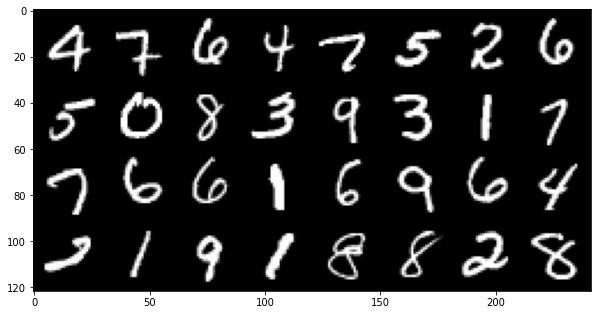

In [6]:
nn_utils.plot_batch(inputs[:32])

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch 1, TrnLoss: 3900.7944, TstLoss: 1174.1968


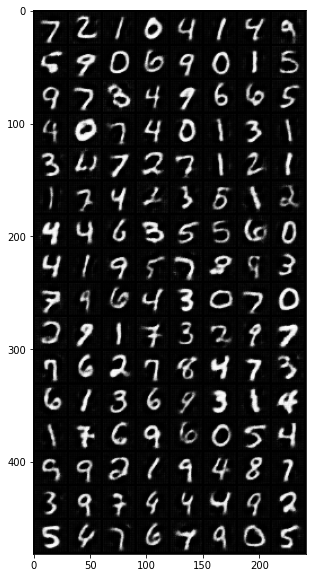

Epoch 2, TrnLoss: 1051.7783, TstLoss: 890.9955
Epoch 3, TrnLoss: 863.0041, TstLoss: 778.2675
Epoch 4, TrnLoss: 775.9364, TstLoss: 717.7815
Epoch 5, TrnLoss: 727.9352, TstLoss: 681.8497
Epoch 6, TrnLoss: 696.9863, TstLoss: 666.0707


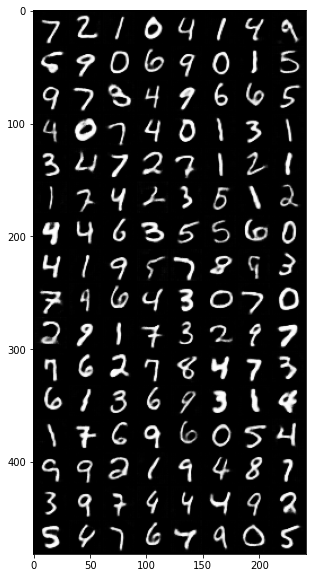

Epoch 7, TrnLoss: 675.0789, TstLoss: 646.9062
Epoch 8, TrnLoss: 656.4096, TstLoss: 630.9318
Epoch 9, TrnLoss: 642.3076, TstLoss: 630.1156
Epoch 10, TrnLoss: 628.8417, TstLoss: 617.7112


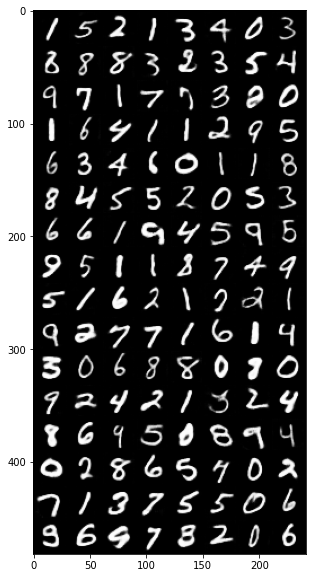

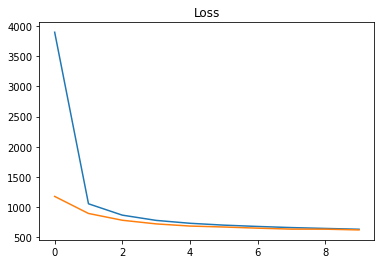

In [7]:
model = VAE(in_shape=(1,28,28), n_latent=28).cuda()
criterion = nn.MSELoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
losses = run(model, trn_loader, tst_loader, criterion, 
                 optimizer, epochs=10, plot_interval=5)
nn_utils.plot_metric(losses['trn'], losses['tst'], 'Loss')

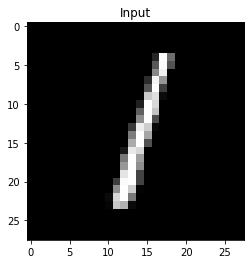

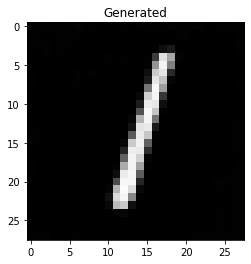

In [8]:
import sys
sys.setrecursionlimit(300000)
img_idx = 2
inputs,targs=next(iter(tst_loader))
recon, mean, var = predict(model, inputs[img_idx])
out = generate(model, mean, var)
nn_utils.plot_batch(inputs[img_idx], title="Input", fs=(4,4)) 
nn_utils.plot_batch(out, title="Generated", fs=(4,4))

In [9]:
trn, tst = datasets.get_mnist_loader(trn_dset, tst_dset, batch_size=100)

x_tr = np.zeros((120000,28,28))
y_tr = np.zeros((120000))

x_te = np.zeros((20000,28,28))
y_te = np.zeros((20000))

i = 0
for trn_inp, trn_tar in trn:
  trn_aug = model.transform(Variable(trn_inp.cuda())).cpu()
  for idx in range(len(trn_inp)):
    arr = np.asarray(torchvision.transforms.ToPILImage()(trn_inp[idx][0]))
    for r in range(28):
      for c in range(28):
        x_tr[i][r][c] = arr[r][c]
    y_tr[i] = trn_tar[idx]
    i += 1
  i -= len(trn_inp)
  for idx in range(len(trn_aug)):
    arr = np.asarray(torchvision.transforms.ToPILImage()(trn_aug[idx][0]))
    for r in range(28):
      for c in range(28):
        x_tr[i+60000][r][c] = arr[r][c]
    y_tr[i+60000] = trn_tar[idx]
    i += 1
  torch.cuda.empty_cache()

i = 0
for tst_inp, tst_tar in tst:
  tst_aug = model.transform(Variable(tst_inp.cuda())).cpu()
  for idx in range(len(tst_inp)):
    arr = np.asarray(torchvision.transforms.ToPILImage()(tst_inp[idx][0]))
    for r in range(28):
      for c in range(28):
        x_te[i][r][c] = arr[r][c]
    y_te[i] = tst_tar[idx]
    i += 1
  i -= len(tst_inp)
  for idx in range(len(tst_aug)):
    arr = np.asarray(torchvision.transforms.ToPILImage()(tst_aug[idx][0]))
    for r in range(28):
      for c in range(28):
        x_te[i+10000][r][c] = arr[r][c]
    y_te[i+10000] = tst_tar[idx]
    i += 1
  torch.cuda.empty_cache()
    
x_train = x_tr
y_train = y_tr
x_test = x_te
y_test = y_te

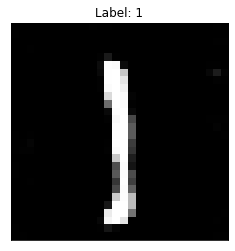

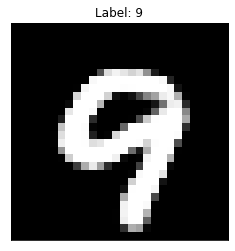

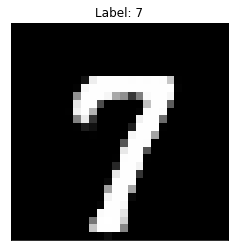

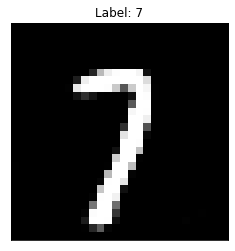

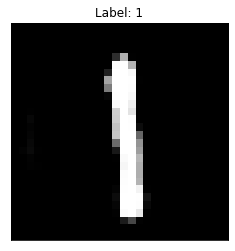

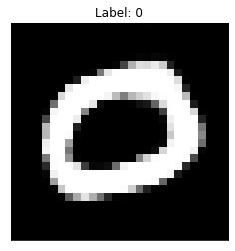

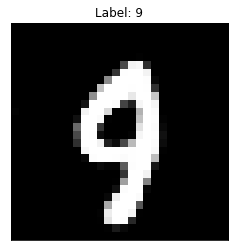

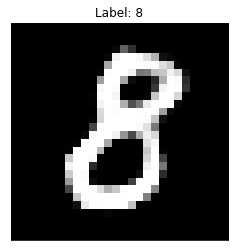

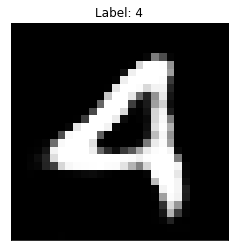

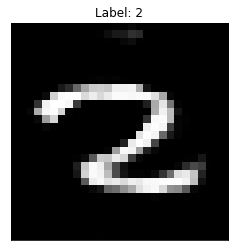

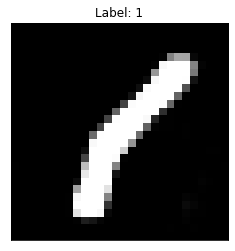

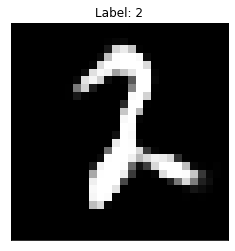

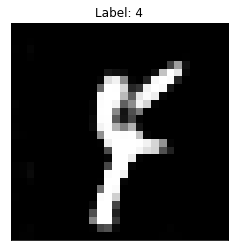

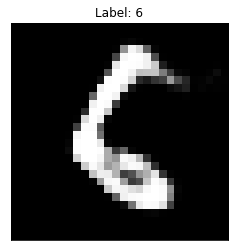

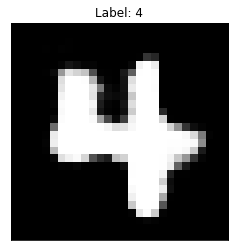

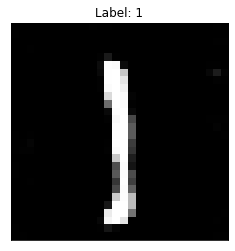

In [10]:
fig = plt.figure()
for i in range(15):
  plt.imshow(x_train[i+60000], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(int(y_train[i+60000])))
  plt.xticks([])
  plt.yticks([])
  plt.show()
fig

In [11]:
init_xtr = x_train[:]
init_xte = x_test[:]

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (120000, 28, 28, 1)
Number of images in x_train 120000
Number of images in x_test 20000


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

model = Sequential()
model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax))
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [13]:
history = model.fit(x=x_train, y=y_train, epochs=5)

Epoch 1/5
120000/120000 [==============================] - 101s 838us/step - loss: 0.1756 - acc: 0.9463
Epoch 2/5
120000/120000 [==============================] - 99s 825us/step - loss: 0.0825 - acc: 0.9741
Epoch 3/5
120000/120000 [==============================] - 99s 824us/step - loss: 0.0621 - acc: 0.9801
Epoch 4/5
120000/120000 [==============================] - 100s 835us/step - loss: 0.0499 - acc: 0.9835
Epoch 5/5
120000/120000 [==============================] - 99s 824us/step - loss: 0.0405 - acc: 0.9863


dict_keys(['loss', 'acc'])


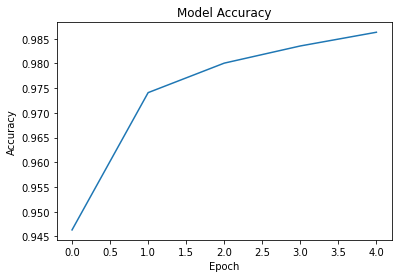

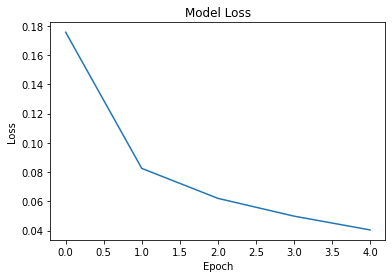

In [14]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

20000/20000 [==============================] - 5s 271us/step

Test accuracy:  0.98075


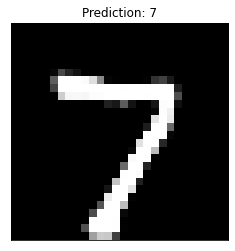

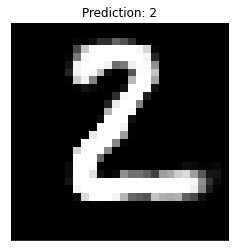

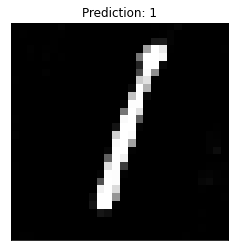

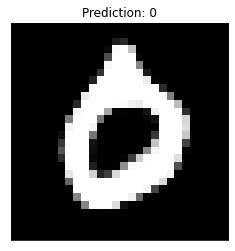

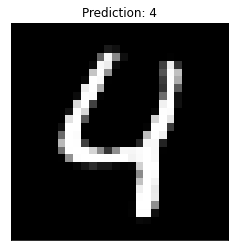

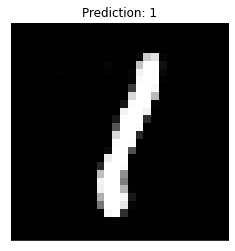

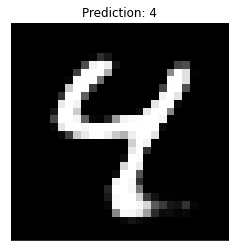

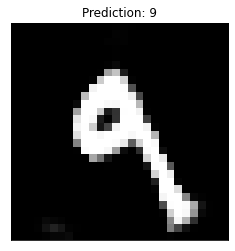

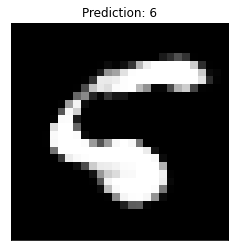

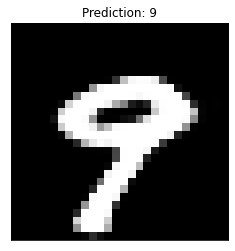

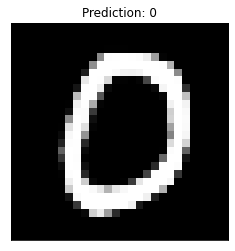

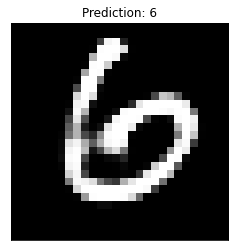

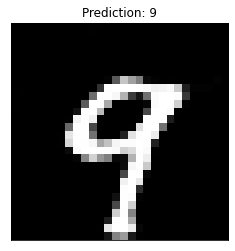

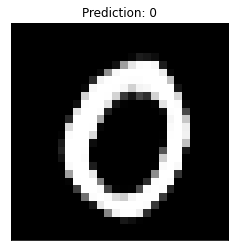

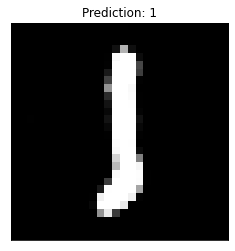

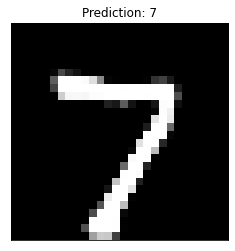

In [15]:
test_loss, test_acc = model.evaluate(x=x_test, y=y_test)
print('\nTest accuracy: ', test_acc)

predictions = model.predict(x_test)
fig = plt.figure()
for i in range(15):
  plt.imshow(init_xte[i+10000], cmap='gray', interpolation='none') #+10000
  plt.title("Prediction: {}".format(np.argmax(predictions[i+10000]))) #+10000
  plt.xticks([])
  plt.yticks([])
  plt.show()
fig

In [16]:
import os
import tempfile
from keras.models import load_model
from vis.visualization import visualize_activation

def apply_modifications(model, custom_objects=None):
    model_path = os.path.join(tempfile.gettempdir(), next(tempfile._get_candidate_names()) + '.h5')
    try:
        model.save(model_path)
        return load_model(model_path, custom_objects=custom_objects)
    finally:
        os.remove(model_path)

from keras import activations
from keras.utils import CustomObjectScope

def k_vis(layer_idx, model):
  print('Layer {}'.format(layer_idx))
  model.layers[layer_idx].activation = activations.linear
  with CustomObjectScope({'softmax_v2': tf.nn.softmax}):
    model = apply_modifications(model)
  for output_idx in np.arange(10):
      img = visualize_activation(model, layer_idx, filter_indices=output_idx, input_range=(0., 1.))
      plt.figure()
      plt.title('Network layer {} perception of {}'.format(layer_idx, output_idx))
      fin = np.zeros((img.shape[0], img.shape[1]), dtype=np.float64)
      for r in range(img.shape[0]):
        for c in range(img.shape[1]):
          fin[r][c] = img[r][c][0]
      plt.imshow(fin)

Layer 3


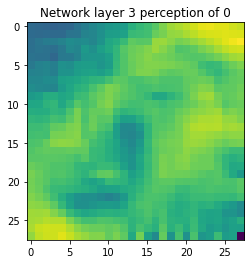

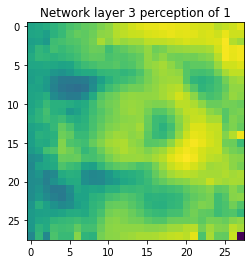

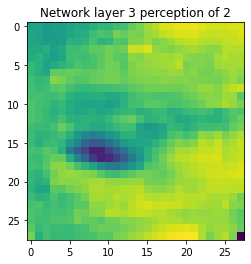

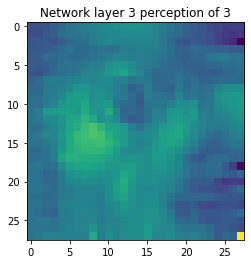

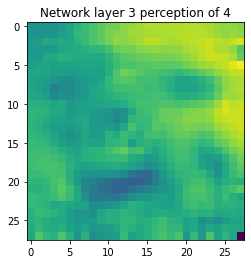

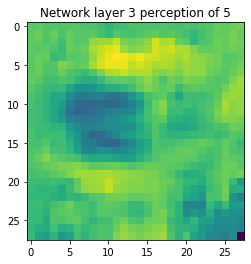

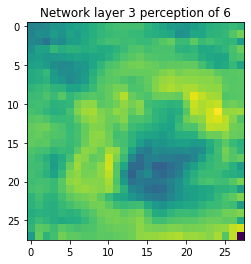

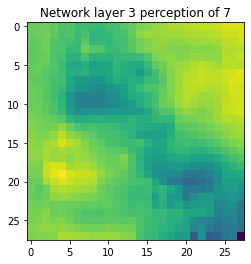

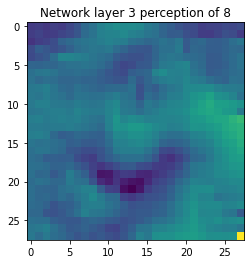

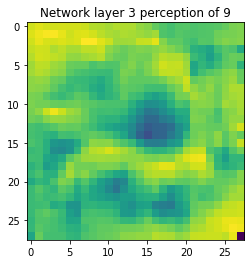

In [17]:
k_vis(3, model)

Layer 5


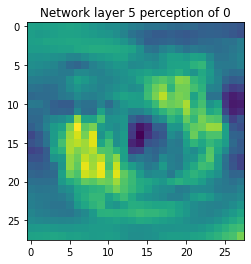

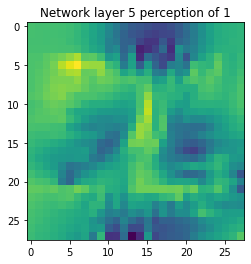

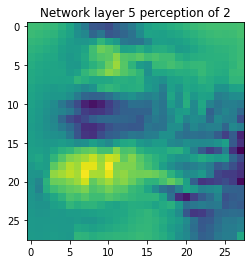

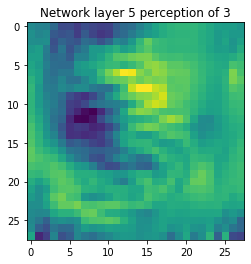

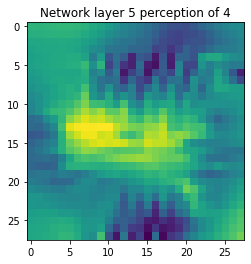

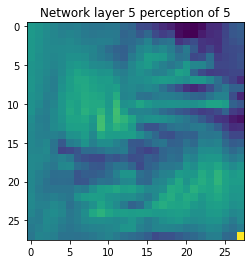

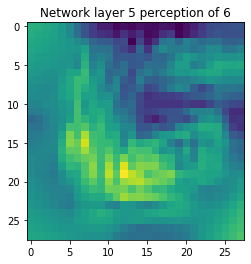

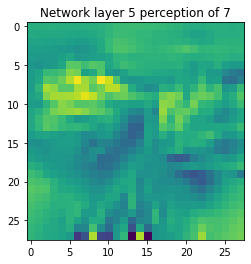

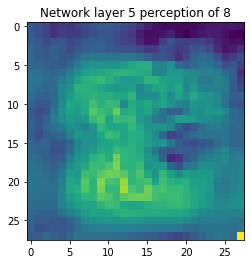

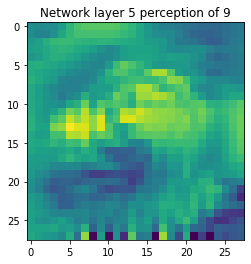

In [18]:
k_vis(5, model)